<a href="https://colab.research.google.com/github/kimhwijin/HandsOnMachineLearing/blob/main/Reinforcement_Learning_18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Display Settings

In [1]:
import sys

IS_COLAB = "google.colab" in sys.modules

if IS_COLAB:
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    %pip install -U tf-agents pyvirtualdisplay
    %pip install -U gym>=0.21.0
    %pip install -U gym[box2d,atari,accept-rom-license]

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [2]:
# !apt-get install -y xvfb x11-utils
# !pip install gym[all]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*
# !apt-get install x11-utils > /dev/null 2>&1 
# !pip install pyglet > /dev/null 2>&1 
# !apt-get install -y xvfb python-opengl > /dev/null 2>&1
# !pip install gym pyvirtualdisplay > /dev/null 2>&1

In [3]:
import gym
from pyvirtualdisplay import Display
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
from tensorflow import keras
import tensorflow as tf
import numpy as np
from collections import deque
mpl.rc('animation', html='jshtml')

/usr/local/lib/python3.7/dist-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [4]:
display = Display(visible=0, size=(600, 400))
display.start()

# Make CartPole V1

In [ ]:
env = gym.make("CartPole-v1")
obs = env.reset()
obs

array([ 0.02155794, -0.04000929,  0.00650975,  0.01618181])

In [ ]:
env.render()

True

In [ ]:
image = env.render(mode="rgb_array")
image.shape

(400, 600, 3)

In [ ]:
env.action_space

Discrete(2)

In [ ]:
action = 1
obs, reward, done, info = env.step(action)
obs, reward, done, info

(array([-0.01096227,  0.22304321, -0.01896007, -0.25703655]), 1.0, False, {})

# Basic Policy ( Not NN )

In [ ]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break

    totals.append(episode_rewards)
    

In [ ]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.626, 8.834598123287783, 24.0, 72.0)

In [39]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img


def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [ ]:
env.seed(42)
frames = []
obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

plot_animation(frames)

# NN Policy

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_inputs = env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(5, activation='selu', input_shape=[n_inputs]),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames


In [ ]:
frames = render_policy_net(model)
plot_animation(frames)

2022-02-08 19:51:57.559671: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-08 19:51:57.561862: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-08 19:51:57.594700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [ ]:
n_environments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
for index, env in enumerate(envs):
    env.seed(index)
np.random.seed(42)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()


Iteration: 4999, Loss: 0.029

In [ ]:
frames = render_policy_net(model)
plot_animation(frames)

#Policy Gradient

In [ ]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        # 모델은 왼쪽으로 움직일 확률을 반환한다.
        left_proba = model(obs[np.newaxis])
        # 정규분포를 샘플링을 통해 확률에 따라 랜덤하게 행동을 선택한다.
        action = (tf.random.uniform([1, 1]) > left_proba)
        # 행동이 왼쪽이면 타깃확률은 1 이고, 오른쪽이면 0 이되도록 타깃을 지정한다. 즉 모든 행동이 옳다고 여김
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        # 이걸로 비용함수를 구한다.
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    
    #모델 파라미터의 기울기를 구한다.
    grads = tape.gradient(loss, model.trainable_variables)
    #확률로 랜덤하게 정한 행동으로 스텝을 진행한다.
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        #각 에피소드는 각 스텝의 보상들과 기울기들을 저장한다.
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            #각 스텝은 보상과 기울기를 저장한다.
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [ ]:
#할인 보상
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    #할인된 미래보상을 중첩해서 현재에 더해야 하기때문에, 끝에서부터 계산한다.
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    #각 할인된 보상
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    
    #1차원 배열로 변경
    flat_rewards = np.concatenate(all_discounted_rewards)
    #평균
    reward_mean = flat_rewards.mean()
    #표준편차
    reward_std = flat_rewards.std()
    #각 할인 보상에 정규화
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [ ]:
#반복 수
n_iterations = 150
#매 반복마다 수행할 에피소드의 수
n_episodes_per_update = 10
#각 에피소드의 최대 스텝수
n_max_steps = 200
#감마
discount_rate = 0.95

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])


# Policy Gradient Train

In [ ]:
env = gym.make("CartPole-v1")
env.seed(42)


for iteration in range(n_iterations):
    #n_episdoes_per_update 만큼 에피소드를 진행하고, 각 스텝마다 model 예측과 loss_fn에 따라 그레디언트를 구한다.
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    
    #여러 에피소드의 보상합
    total_rewards = sum(map(sum, all_rewards))                     # Not shown in the book
    print("\rIteration: {}, mean rewards: {:.1f}".format(          # Not shown
        iteration, total_rewards / n_episodes_per_update), end="") # Not shown
    
    #보상 정규화
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)


    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            #각 에피소드별, 각 스텝별, 각 모델 파라미터별 그레디언트와 보상을 곱해서 적용한다.
            [final_reward * all_grads[episode_index][step][var_index]
            #에피소드 별 보상
             for episode_index, final_rewards in enumerate(all_final_rewards)
                #스텝 별 보상
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    #여러번의 에피소드에서 모아둔 그레디언트를 보상과 곱해서 평균한후 한꺼번에 적용시킨다.
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

Iteration: 149, mean rewards: 185.0

In [ ]:
frames = render_policy_net(model)
plot_animation(frames)

# Markov Decision Process

In [ ]:
transition_probabilities = [ # shape=[s, a, s']
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None]]
rewards = [ # shape=[s, a, s']
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]

In [ ]:
#state : 3개, 모든 가능한 행동 : 3개
Q_values = np.full((3, 3), -np.inf) # 불가능한 행동은 -np.inf
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # 모든 가능한 행동에 대해

In [ ]:
gamma = 0.90  # 할인 계수

history1 = []
#Q-value 반복
for iteration in range(50):
    Q_prev = Q_values.copy()
    #Q_prev : 이전 행동에 따른 보상의 합, 이번 상태에 오기전까지 Q-value
    history1.append(Q_prev)
    #상태 0 1 2
    for s in range(3):
        #행동 0 ... 2
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    #전이 확률
                    transition_probabilities[s][a][sp]
                    #곱하기 (현재 보상 + 할인된 과거 보상의 합)
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                #모든 s에 대해서
                for sp in range(3)])

history1 = np.array(history1)

In [ ]:
print(Q_values, np.argmax(Q_values, axis=1), sep='\n')
# 상태 0 -> 행동 0, 상태 1 -> 행동 0, 상태 2 -> 행동 1

[[18.91891892 17.02702702 13.62162162]
 [ 0.                -inf -4.87971488]
 [       -inf 50.13365013        -inf]]
[0 0 1]


In [ ]:
#할인 계수를 높임 -> 미래가치에 더 높은 가중치를 둠
Q_values = np.full((3, 3), -np.inf) # 불가능한 행동에 대해서는 -np.inf
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # 모든 가능한 행동에 대해서

gamma = 0.95  # 할인 계수
for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp] * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp])) for sp in range(3)
                    ])


In [ ]:
print(Q_values, np.argmax(Q_values, axis=1), sep='\n')
# 상태 0 -> 행동 0, 상태 1 -> 행동 2, 상태 2 -> 행동 1

[[21.73304188 20.63807938 16.70138772]
 [ 0.95462106        -inf  1.01361207]
 [       -inf 53.70728682        -inf]]
[0 2 1]


# Q-learning

In [ ]:
#에이전트가 전이확률과 보상을 모르기때문에, 환경을 만들어줘야한다.
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward


#에이전트가 다음행동을 결정하는 정책 -> 여기선 랜덤
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [ ]:
np.random.seed(42)

#Q-value 초기화
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0


alpha0 = 0.05 # 초기 학습률
decay = 0.005 # 학습률 감쇄
gamma = 0.90 # 할인 계수
state = 0 # 초기 상태
history2 = []

#탐험수
for iteration in range(10000):
    history2.append(Q_values.copy())
    
    #탐험 정책에 따라서 현재 상태에 다음 행동을 결정한다.
    action = exploration_policy(state)
    #현재 상태와 행동을 통해서 확률적으로 다음 상태와 보상을 받는다.
    next_state, reward = step(state, action)
    #미래에 최적의 행동을 한다고 가정하고, 다음 상태의 최대 Q-value 를 받는다.
    next_value = np.max(Q_values[next_state]) # 다음 스텝의 그리디 정책
    
    #학습률 감쇠
    alpha = alpha0 / (1 + iteration * decay)
    
    #이동평균
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2) # 책에는 없음

In [ ]:
Q_values

array([[18.77621289, 17.2238872 , 13.74543343],
       [ 0.        ,        -inf, -8.00485647],
       [       -inf, 49.40208921,        -inf]])

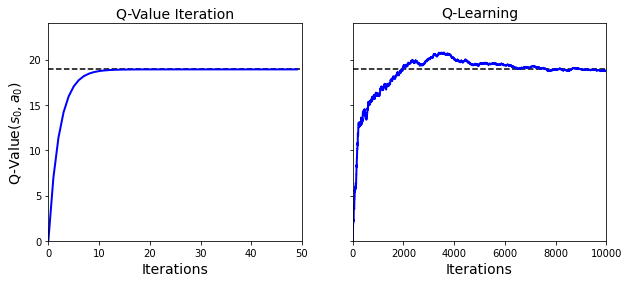

In [ ]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)

for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])


# Deep Q-network

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# CartPole V1

In [ ]:
env = gym.make('CartPole-v1')
input_shape = env.observation_space.shape
n_outputs = env.action_space.n
input_shape, n_outputs

((4,), 2)

# DQN Model

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(32, activation='elu', input_shape=input_shape),
    keras.layers.Dense(32, activation='elu'),
    keras.layers.Dense(n_outputs)
])

# Policy

In [ ]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_value = model.predict(state[np.newaxis])
        return np.argmax(Q_value[0])

# Reverb Memory

In [ ]:
# (obs, action, reward, next_obs, done)
replay_memory = deque(maxlen=3000)

In [ ]:
#Reverb Memory to Experience [states, actions, rewards, next_obs, dones] ( apply batch )
def sample_experience(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    #각 column 들을 각 배열로 바꾸는 과정
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)
    ]
    return states, actions, rewards, next_states, dones

In [ ]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

# DQN Train Step

In [ ]:
batch_size = 32
discount_rate = 0.95 # gamma
optmizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experience(batch_size)
    states, actions, rewards, next_states, dones = experiences # 5, batch_size, 1
    next_Q_values = model.predict(next_states) #batch_size, n_actions
    max_next_Q_values = np.max(next_Q_values, axis=1) #batch_size , 1
    target_Q_values = (
        rewards + 
        (1 - done) * discount_rate * max_next_Q_values) #batch_size, 1
    target_Q_values = target_Q_values.reshape(-1, 1) # batch_size,
    mask = tf.one_hot(actions, depth=n_outputs) # batch_size, n_actions
    with tf.GradientTape() as tape:
        all_Q_values = model(states) #batch_size, 1 -> batch_size, n_actions
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True) # batch_size, 1
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values)) #1,
    grads = tape.gradient(loss, model.trainable_variables)
    optmizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

# DQN Train

In [ ]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = [] 
best_score = 0

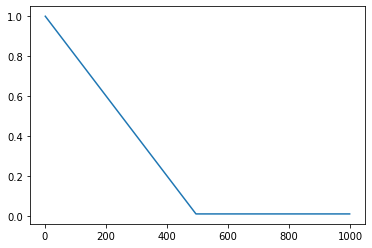

In [ ]:
epsilon = np.array([max(1-y/500, 0.01) for y in range(1, 1000)])
plt.plot(np.arange(1, 1000), epsilon)
plt.show()

In [ ]:
for episode in range(600):

    obs = env.reset()
    #200 step 수행후 저장
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01) 
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    #각 에피소드의 최고 step 수를 best_score 에 저장함. (여기선 음수 보상이없고 스텝자체가 보상임)
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, Best Score: {}, eps: {:.3f}".format(episode+1, step + 1, best_score ,epsilon), end="") # Not shown
    # 아마도 deque를 채우고 훈련하는 듯
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

Episode: 600, Steps: 151, Best Score: 199, eps: 0.010

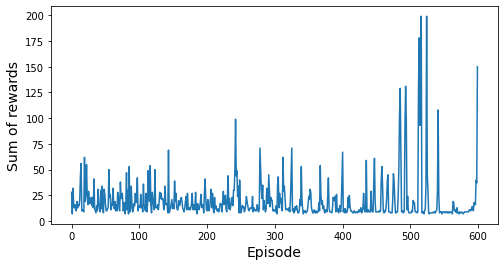

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

In [ ]:
state = env.reset()
frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
print(len(frames))
plot_animation(frames)

200


# Double DQN

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=[4]),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [ ]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=6e-3)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experience(batch_size)
    states, actions, rewards, next_states, dones = experiences
    #Predict Model
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    #Target Model
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
replay_memory = deque(maxlen=2000)

In [ ]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, Best SCore: {}, eps: {:.3f}".format(episode, step + 1, best_score, epsilon), end="")
    if episode >= 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())
    # Alternatively, you can do soft updates at each step:
    #if episode >= 50:
        #target_weights = target.get_weights()
        #online_weights = model.get_weights()
        #for index in range(len(target_weights)):
        #    target_weights[index] = 0.99 * target_weights[index] + 0.01 * online_weights[index]
        #target.set_weights(target_weights)

model.set_weights(best_weights)

Episode: 599, Steps: 86, eps: 0.010

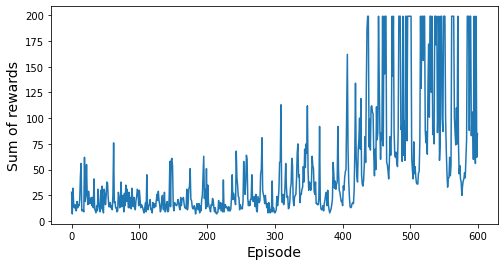

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()


In [ ]:
state = env.reset()
frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
print(len(frames))
plot_animation(frames)

200


# Dueling Double DQN

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
input_states = keras.layers.Input(shape=[4])
hidden1 = keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)

#V(s) 추정
state_values = keras.layers.Dense(1)(hidden2)
#각 행동에 대한 이익 A(s, a) 추정
raw_advantages = keras.layers.Dense(n_outputs)(hidden2)
# 최적의 행동 a* 에 대한 최대 이익을 0 으로 조정
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
#Q(s, a) 추정
Q_values = state_values + advantages
model = keras.models.Model(inputs=[input_states], outputs=[Q_values])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [ ]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=7.5e-3)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experience(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
replay_memory = deque(maxlen=2000)

In [ ]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode >= 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

Episode: 599, Steps: 200, eps: 0.010

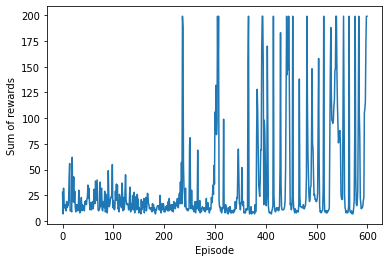

In [ ]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.show()

In [ ]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)

print(len(frames))
plot_animation(frames)

200


In [ ]:
env.close()

# TF-Agents

In [5]:
from tf_agents.environments import suite_gym

env = suite_gym.load("Breakout-v4")


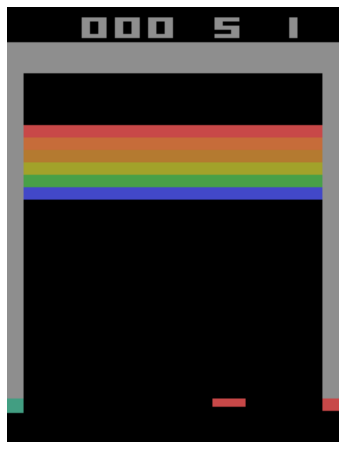

In [6]:
env.seed(42)
env.reset()

img = env.render(mode="rgb_array")

plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis("off")
plt.show()

# Specification

In [7]:
env.observation_spec(), env.action_spec(),env.gym.get_action_meanings() #, env.step_spec()

(BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255),
 BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=3),
 ['NOOP', 'FIRE', 'RIGHT', 'LEFT'])

# Environment Wrapper

In [8]:
from tf_agents.environments.wrappers import ActionRepeat

repeating_env = ActionRepeat(env, times=4)
repeating_env

In [9]:
repeating_env.unwrapped

# Gym Wrapper

In [10]:
from gym.wrappers import TimeLimit

limited_repeating_env = suite_gym.load(
    "Breakout-v4",
    gym_env_wrappers=[lambda env: TimeLimit(env, max_episode_steps=10000)],
    env_wrappers=[lambda env: ActionRepeat(env, times=4)]
)

from functools import partial

limited_repeating_env = suite_gym.load(
    "Breakout-v4",
    gym_env_wrappers=[partial(TimeLimit, max_episode_steps=10000)],
    env_wrappers=[partial(ActionRepeat, times=4)],
)

# BreakOut Preprocessing Wrapper

In [11]:
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

max_episode_steps = 27000 # <=> 108k ALE frames since 1 step = 4 frames
environment_name = "BreakoutNoFrameskip-v4"

class AtariPreprocessingWithAutoFire(AtariPreprocessing):
    def reset(self, **kwargs):
        obs = super().reset(**kwargs)
        super().step(1) # FIRE to start
        return obs
    def step(self, action):
        lives_before_action = self.ale.lives()
        obs, rewards, done, info = super().step(action)
        if self.ale.lives() < lives_before_action and not done:
            super().step(1) # action 1 : fire 새로시작
        return obs, rewards, done, info

env = suite_atari.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessingWithAutoFire, FrameStack4])

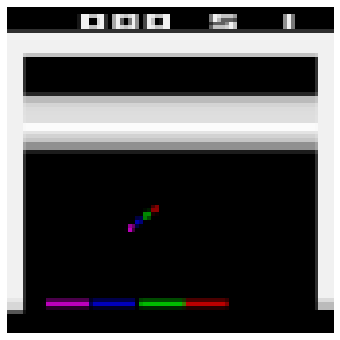

In [12]:
env.seed(42)
env.reset()
for _ in range(4):
    time_step = env.step(3) # 왼쪽
def plot_observation(obs):
    # 컬러 채널이 3개이기 때문에 4 프레임을 출력할 수 없습니다.
    # 따라서 현재 프레임과 다른 프레임의 평균 값을 뺀 차이를 계산합니다.
    # 그다음 이 차이를 현재 프레임의 빨강과 파랑 채널에 더해서 보라 색을 구합니다.
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")
plt.figure(figsize=(6, 6))
plot_observation(time_step.observation)
plt.show()

In [13]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment

tf_env = TFPyEnvironment(env)

# TF-Agents DQN

In [14]:
from tf_agents.networks.q_network import QNetwork

preprocessing_layer = keras.layers.Lambda(lambda obs: tf.cast(obs, np.float32) / 255.)
conv_layer_params=[(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params=[512]

#옵저버를 입력으로 받고, 행동마다 하나의 Q-value 값을 출력

q_net = QNetwork(
    #환경 스펙
    tf_env.observation_spec(),
    #행동 스펙
    tf_env.action_spec(),
    #전처리 층
    preprocessing_layers=preprocessing_layer,
    #합성곱 층 구조
    conv_layer_params=conv_layer_params,
    #밀집층 구조
    fc_layer_params=fc_layer_params)


# Agents

In [15]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

train_step = tf.Variable(0)
update_period = 4
#dqn 논문과 동일
optimizer = keras.optimizers.RMSprop(learning_rate=2.5e-4, rho=0.95, momentum=0.0, epsilon=0.00001, centered=True)
#epsilon 변화량 ( 랜덤선택 확률 )
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=1.0, decay_steps=250000 // update_period, end_learning_rate=0.01)

agent = DqnAgent(tf_env.time_step_spec(), 
                 tf_env.action_spec(), 
                 q_network=q_net, 
                 optimizer=optimizer, 
                 target_update_period=2000, 
                 td_errors_loss_fn=keras.losses.Huber(reduction='none'), # 샘플마다 하나의 오차를 반환하기 때문에 reduction='none' 으로 지정한다.
                 gamma=0.99, 
                 train_step_counter=train_step, 
                 epsilon_greedy=lambda: epsilon_fn(train_step)
                 )

agent.initialize()

# Replay Buffer

In [16]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec, #데이터 스펙
    batch_size=tf_env.batch_size, #각 스텝에서 추가될 데이터 개수
    max_length=100000 # 재생 버퍼 최대 크기
)

# Observer

In [17]:
replay_buffer_observer = replay_buffer.add_batch #옵저버 정의, 경로 매개변수를 받는 단순한 함수 형태

In [18]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")
#observer 로서  __call__ 메서드에 trajectory 를 받는 형태면 다 가능

# Metrics

In [20]:
from tf_agents.metrics import tf_metrics
train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

# Driver

In [24]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics, # 재생 버퍼와, 지표에 추가함
    num_steps=update_period # 각 훈련 반복마다 스텝을 4개 추가한다.
)

# Initial Replay Buffer

In [25]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),
                                        tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy, #랜덤 정책으로
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000) # 8만번의 프레임을 수행해서 버퍼를 채워넣는다.
final_time_step, final_policy_state = init_driver.run()

20000/20000

# Dataset

In [26]:
trajectories, buffer_info = next(iter(replay_buffer.as_dataset(
    sample_batch_size=2,
    num_steps=3,
    single_deterministic_pass=False)))

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [27]:
trajectories._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [32]:
trajectories.observation.shape,  trajectories.reward.shape

(TensorShape([2, 3, 84, 84, 4]), TensorShape([2, 3]))

In [31]:
trajectories.step_type

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

In [29]:
from tf_agents.trajectories.trajectory import to_transition

time_steps, action_steps, next_time_steps = to_transition(trajectories)
time_steps.observation.shape

TensorShape([2, 2, 84, 84, 4])

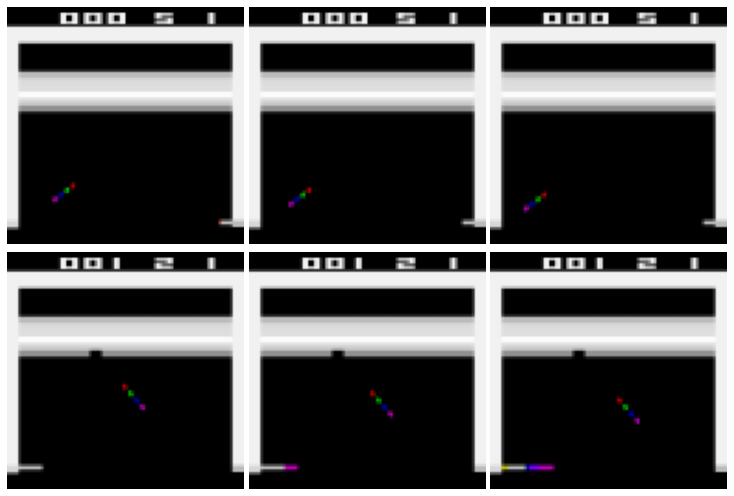

In [30]:
plt.figure(figsize=(10, 6.8))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row * 3 + col + 1)
        plot_observation(trajectories.observation[row, col].numpy())
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0.02)
plt.show()
#가로 : 연속된 3개의 에피소드


In [33]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3).prefetch(3)

# Train

In [34]:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

In [35]:
from tf_agents.eval.metric_utils import log_metrics
import logging
logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


In [36]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss:{:.5f}".format(
            iteration, train_loss.loss.numpy()), end="")
        if iteration % 1000 == 0:
            log_metrics(train_metrics)

In [37]:
train_agent(n_iterations=50000)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 4
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


998 loss:0.00028

INFO:absl: 
		 NumberOfEpisodes = 23
		 EnvironmentSteps = 4004
		 AverageReturn = 1.7999999523162842
		 AverageEpisodeLength = 186.6999969482422


1993 loss:0.00025

INFO:absl: 
		 NumberOfEpisodes = 46
		 EnvironmentSteps = 8004
		 AverageReturn = 1.600000023841858
		 AverageEpisodeLength = 176.39999389648438


2994 loss:0.00006

INFO:absl: 
		 NumberOfEpisodes = 68
		 EnvironmentSteps = 12004
		 AverageReturn = 0.6000000238418579
		 AverageEpisodeLength = 190.8000030517578


3995 loss:0.00042

INFO:absl: 
		 NumberOfEpisodes = 91
		 EnvironmentSteps = 16004
		 AverageReturn = 0.4000000059604645
		 AverageEpisodeLength = 134.10000610351562


4996 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 117
		 EnvironmentSteps = 20004
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 180.8000030517578


5995 loss:0.00012

INFO:absl: 
		 NumberOfEpisodes = 139
		 EnvironmentSteps = 24004
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 164.3000030517578


6992 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 163
		 EnvironmentSteps = 28004
		 AverageReturn = 0.8999999761581421
		 AverageEpisodeLength = 152.8000030517578


7992 loss:0.00009

INFO:absl: 
		 NumberOfEpisodes = 187
		 EnvironmentSteps = 32004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 155.0


8994 loss:0.00019

INFO:absl: 
		 NumberOfEpisodes = 210
		 EnvironmentSteps = 36004
		 AverageReturn = 1.0
		 AverageEpisodeLength = 176.0


9998 loss:0.00007

INFO:absl: 
		 NumberOfEpisodes = 233
		 EnvironmentSteps = 40004
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 159.3000030517578


10994 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 257
		 EnvironmentSteps = 44004
		 AverageReturn = 1.7000000476837158
		 AverageEpisodeLength = 181.89999389648438


11999 loss:0.00022

INFO:absl: 
		 NumberOfEpisodes = 277
		 EnvironmentSteps = 48004
		 AverageReturn = 1.7999999523162842
		 AverageEpisodeLength = 184.6999969482422


12999 loss:0.00037

INFO:absl: 
		 NumberOfEpisodes = 299
		 EnvironmentSteps = 52004
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 203.8000030517578


13998 loss:0.00003

INFO:absl: 
		 NumberOfEpisodes = 322
		 EnvironmentSteps = 56004
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 155.89999389648438


14996 loss:0.00007

INFO:absl: 
		 NumberOfEpisodes = 343
		 EnvironmentSteps = 60004
		 AverageReturn = 1.5
		 AverageEpisodeLength = 176.10000610351562


15992 loss:0.00004

INFO:absl: 
		 NumberOfEpisodes = 360
		 EnvironmentSteps = 64004
		 AverageReturn = 2.200000047683716
		 AverageEpisodeLength = 202.10000610351562


16992 loss:0.00050

INFO:absl: 
		 NumberOfEpisodes = 383
		 EnvironmentSteps = 68004
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 176.8000030517578


17999 loss:0.00013

INFO:absl: 
		 NumberOfEpisodes = 404
		 EnvironmentSteps = 72004
		 AverageReturn = 1.100000023841858
		 AverageEpisodeLength = 156.3000030517578


18993 loss:0.00018

INFO:absl: 
		 NumberOfEpisodes = 428
		 EnvironmentSteps = 76004
		 AverageReturn = 1.5
		 AverageEpisodeLength = 169.39999389648438


19998 loss:0.00013

INFO:absl: 
		 NumberOfEpisodes = 446
		 EnvironmentSteps = 80004
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 214.0


20999 loss:0.00038

INFO:absl: 
		 NumberOfEpisodes = 469
		 EnvironmentSteps = 84004
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 192.5


21994 loss:0.00039

INFO:absl: 
		 NumberOfEpisodes = 491
		 EnvironmentSteps = 88004
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 165.39999389648438


22993 loss:0.00029

INFO:absl: 
		 NumberOfEpisodes = 515
		 EnvironmentSteps = 92004
		 AverageReturn = 0.800000011920929
		 AverageEpisodeLength = 147.8000030517578


23995 loss:0.00024

INFO:absl: 
		 NumberOfEpisodes = 537
		 EnvironmentSteps = 96004
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 186.10000610351562


24994 loss:0.00072

INFO:absl: 
		 NumberOfEpisodes = 556
		 EnvironmentSteps = 100004
		 AverageReturn = 2.200000047683716
		 AverageEpisodeLength = 225.6999969482422


25995 loss:0.00033

INFO:absl: 
		 NumberOfEpisodes = 579
		 EnvironmentSteps = 104004
		 AverageReturn = 1.2000000476837158
		 AverageEpisodeLength = 165.3000030517578


26995 loss:0.00006

INFO:absl: 
		 NumberOfEpisodes = 597
		 EnvironmentSteps = 108004
		 AverageReturn = 1.600000023841858
		 AverageEpisodeLength = 191.0


27999 loss:0.00007

INFO:absl: 
		 NumberOfEpisodes = 616
		 EnvironmentSteps = 112004
		 AverageReturn = 1.399999976158142
		 AverageEpisodeLength = 189.3000030517578


28994 loss:0.00027

INFO:absl: 
		 NumberOfEpisodes = 634
		 EnvironmentSteps = 116004
		 AverageReturn = 1.7000000476837158
		 AverageEpisodeLength = 206.5


29998 loss:0.00028

INFO:absl: 
		 NumberOfEpisodes = 654
		 EnvironmentSteps = 120004
		 AverageReturn = 1.5
		 AverageEpisodeLength = 167.89999389648438


30994 loss:0.00083

INFO:absl: 
		 NumberOfEpisodes = 673
		 EnvironmentSteps = 124004
		 AverageReturn = 1.2999999523162842
		 AverageEpisodeLength = 164.1999969482422


31994 loss:0.00026

INFO:absl: 
		 NumberOfEpisodes = 691
		 EnvironmentSteps = 128004
		 AverageReturn = 1.5
		 AverageEpisodeLength = 187.6999969482422


32993 loss:0.00043

INFO:absl: 
		 NumberOfEpisodes = 711
		 EnvironmentSteps = 132004
		 AverageReturn = 1.7999999523162842
		 AverageEpisodeLength = 182.60000610351562


33998 loss:0.00170

INFO:absl: 
		 NumberOfEpisodes = 729
		 EnvironmentSteps = 136004
		 AverageReturn = 1.7000000476837158
		 AverageEpisodeLength = 241.3000030517578


34994 loss:0.00024

INFO:absl: 
		 NumberOfEpisodes = 748
		 EnvironmentSteps = 140004
		 AverageReturn = 1.7999999523162842
		 AverageEpisodeLength = 203.60000610351562


35993 loss:0.00067

INFO:absl: 
		 NumberOfEpisodes = 766
		 EnvironmentSteps = 144004
		 AverageReturn = 2.0999999046325684
		 AverageEpisodeLength = 199.3000030517578


36996 loss:0.00466

INFO:absl: 
		 NumberOfEpisodes = 785
		 EnvironmentSteps = 148004
		 AverageReturn = 1.7999999523162842
		 AverageEpisodeLength = 179.10000610351562


37999 loss:0.00015

INFO:absl: 
		 NumberOfEpisodes = 804
		 EnvironmentSteps = 152004
		 AverageReturn = 2.0
		 AverageEpisodeLength = 219.1999969482422


38992 loss:0.00025

INFO:absl: 
		 NumberOfEpisodes = 820
		 EnvironmentSteps = 156004
		 AverageReturn = 2.200000047683716
		 AverageEpisodeLength = 244.0


39997 loss:0.00044

INFO:absl: 
		 NumberOfEpisodes = 835
		 EnvironmentSteps = 160004
		 AverageReturn = 3.299999952316284
		 AverageEpisodeLength = 252.0


40998 loss:0.00431

INFO:absl: 
		 NumberOfEpisodes = 853
		 EnvironmentSteps = 164004
		 AverageReturn = 3.200000047683716
		 AverageEpisodeLength = 214.10000610351562


41992 loss:0.00039

INFO:absl: 
		 NumberOfEpisodes = 867
		 EnvironmentSteps = 168004
		 AverageReturn = 4.300000190734863
		 AverageEpisodeLength = 289.0


42995 loss:0.00070

INFO:absl: 
		 NumberOfEpisodes = 880
		 EnvironmentSteps = 172004
		 AverageReturn = 4.199999809265137
		 AverageEpisodeLength = 278.70001220703125


43994 loss:0.00039

INFO:absl: 
		 NumberOfEpisodes = 893
		 EnvironmentSteps = 176004
		 AverageReturn = 4.699999809265137
		 AverageEpisodeLength = 279.79998779296875


44996 loss:0.00028

INFO:absl: 
		 NumberOfEpisodes = 908
		 EnvironmentSteps = 180004
		 AverageReturn = 4.699999809265137
		 AverageEpisodeLength = 260.6000061035156


45995 loss:0.00077

INFO:absl: 
		 NumberOfEpisodes = 921
		 EnvironmentSteps = 184004
		 AverageReturn = 5.699999809265137
		 AverageEpisodeLength = 303.8999938964844


46997 loss:0.00074

INFO:absl: 
		 NumberOfEpisodes = 934
		 EnvironmentSteps = 188004
		 AverageReturn = 7.199999809265137
		 AverageEpisodeLength = 298.79998779296875


47996 loss:0.00891

INFO:absl: 
		 NumberOfEpisodes = 945
		 EnvironmentSteps = 192004
		 AverageReturn = 6.0
		 AverageEpisodeLength = 389.29998779296875


48997 loss:0.00098

INFO:absl: 
		 NumberOfEpisodes = 958
		 EnvironmentSteps = 196004
		 AverageReturn = 6.699999809265137
		 AverageEpisodeLength = 322.3999938964844


49999 loss:0.00105

In [49]:
frames = []
def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, ShowProgress(1000)],
    num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()

plot_animation(frames)

900/1000

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


1000/1000

In [50]:
import PIL
import os
image_path = os.path.join("breakout.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:150]]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)

In [51]:

%%html
<img src="images/rl/breakout.gif" />